# Indirect Tensile Strength

In [20]:
#%% IMPORTS
#BASICS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import absolute
from pandas.plotting import scatter_matrix
from sklearn.pipeline import make_pipeline
from IPython.display import display, Markdown, Latex
pd.options.display.max_columns = None

#STATISTICS
from scipy.stats import normaltest
from scipy import stats

#ML TRAINING AND DATA PREPROCESSING
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PolynomialFeatures

#ML MODELS
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance

#MODEL EVALUATION
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

#METRICS
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## 1. Methods

In [21]:
#Eliminate Outliers based on the interquantile
#datFrame: Data frame where the outliers will be eliminated.
#columnName: the name of the column where the outliers will be identified.
def eliminateOutliers (dataFrame, columnName):
    Q1 = dataFrame[columnName].quantile(0.25)
    Q3 = dataFrame[columnName].quantile(0.75)
    IQR = Q3 - Q1
    print('Initial dataframe size: '+str(dataFrame.shape))
    dataFrame = dataFrame[(dataFrame[columnName] < (Q3 + 1.5 * IQR)) & (dataFrame[columnName] > (Q1 - 1.5 * IQR))]
    print('Final dataframe size: '+str(dataFrame.shape))
    return dataFrame

In [22]:
# Create the boxplot graphs for the categorical variables
# dataFrame: Data frame associated to the property of interest (dfAirVoids, dfMS, dfMF, dfITS, dfTSR)
# propertyOfInterest: the name of the column where the property of interest is located.
# columnName1...4: The categorical columns to evaluate.
def displayBoxPlotGraphs (dataFrame, propertyOfInterest, columnName1, columnName2, columnName3, columnName4):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
    sns.boxplot(y = propertyOfInterest, x = columnName1, data=dataFrame,  orient='v' , ax=ax1)
    sns.boxplot(y = propertyOfInterest, x = columnName2, data=dataFrame,  orient='v' , ax=ax2)
    sns.boxplot(y = propertyOfInterest, x= columnName3, data=dataFrame,  orient='v' , ax=ax3)
    sns.boxplot(y= propertyOfInterest, x= columnName4, data=dataFrame,  orient='v' , ax=ax4)

In [23]:
#Method that print the best parameters, R2 and MSE based on a grid search.
def printBestModel (grid):
    mse = grid.best_score_
    print('Best Parameters:' , grid.best_params_)
    print('Best MSE:' + str(-mse))

## 2. Data Import

In [24]:
#%%DATA READING AND INITIAL PREPROCESSING
numericColumns = ['Aggregate absorption (%)',
                  'Apparent specific gravity',
                    0.075,
                    0.3,
                    0.6,
                    2.36,
                    4.75,
                    9.5,
                    12.5,
                    19,
                    'Plastic particle size (mm)',
                    'Mixing speed (RPM)',
                    'Mixing Temperature',
                    'Mixing Time (hours)',
                    'Plastic Addition by bitumen weight (%)',
                    'Bitumen content in the sample'
                    ]
categoricalColumns = ['Modified asphalt Mix?',
                      'Agreggate Type',
                    'Aggregate absorption (%)',
                    'Filler used',
                    'Consolidated bitumen penetration grade',
                    'New Plastic Type',
                    'Plastic pretreatment',
                    'Plastic shape',
                    'Plastic Size',
                    'Mixing Process',
                    'Plastic melted previous to addition?',
                    'Aggregates replacement ?',
                    'Bitumen replacement?',
                    'Filler replacement',
                    'Property',
                    'Units']
#It returns the dataframe of interes based on the property - 'AirVoids', 'MS', 'MF', 'ITS', 'TSR'
def returnDf (propertyOfInterest):
    df = pd.read_excel('fileML.xlsx', sheet_name = propertyOfInterest, engine='openpyxl')
    df = df.set_index(propertyOfInterest + ' ID')
    df.loc[:,:'Units'] = df.loc[:,:'Units'].applymap(str)
    df.loc[:,:'Units'] = df.loc[:,:'Units'] .applymap(str.strip)
    df.replace('NS', np.nan, inplace = True)
    df[numericColumns] = df[numericColumns].replace('N/a', 0).astype(float)
    return df

In [25]:
dfITS = returnDf('ITS')

## 3. Data Exploration
###  3.1 Total Sample

In [26]:
dfITS = eliminateOutliers(dfITS, 'ITS of the sample [Mpa]')
dfITSModified = dfITS[dfITS['Modified asphalt Mix?'] == 'Yes']
dfITSModified.iloc[:,2:].describe(include = "all")

Initial dataframe size: (129, 34)
Final dataframe size: (121, 34)


Modified asphalt Mix? Agreggate Type  Aggregate absorption (%)  \
count                    105             49                 84.000000   
unique                     1              3                       NaN   
top                      Yes      Limestone                       NaN   
freq                     105             31                       NaN   
mean                     NaN            NaN                  0.975357   
std                      NaN            NaN                  0.958954   
min                      NaN            NaN                  0.100000   
25%                      NaN            NaN                  0.100000   
50%                      NaN            NaN                  0.560000   
75%                      NaN            NaN                  2.375000   
max                      NaN            NaN                  2.700000   

        Apparent specific gravity       0.075         0.3         0.6  \
count                   48.000000  102.000000  102.000000  105.000000   
unique                        NaN         NaN         NaN         NaN   
top                           NaN         NaN         NaN         NaN   
freq                          NaN         NaN         NaN         NaN   
mean                     2.663083    6.089510   14.218627   23.052000   
std                      0.063249    1.641458    2.538724    7.129505   
min                      2.600000    2.990000    5.300000   10.070000   
25%                      2.600000    4.592500   12.432500   18.900000   
50%                      2.658500    5.980000   14.000000   21.250000   
75%                      2.720000    7.000000   16.280000   28.000000   
max                      2.800000    9.700000   23.000000   39.160000   

              2.36        4.75         9.5        12.5          19  \
count   105.000000  105.000000  105.000000  105.000000  105.000000   
unique         NaN         NaN         NaN         NaN         NaN   
top            NaN         NaN         NaN         NaN         NaN   
freq           NaN         NaN         NaN         NaN         NaN   
mean     38.133905   52.150476   73.282857   86.570952   95.039810   
std       9.777670   10.936685    9.894570    8.929621    5.228236   
min      19.770000   23.950000   57.350000   73.040000   89.000000   
25%      33.000000   50.130000   65.000000   79.860000   89.220000   
50%      38.800000   54.770000   70.490000   80.000000   97.230000   
75%      47.000000   54.830000   77.500000   95.090000  100.000000   
max      54.100000   71.080000   96.870000  100.000000  100.000000   

       Filler used Bitumen Type Penetration Grade  \
count           26                            105   
unique           5                              5   
top      Limestone                          60/70   
freq             9                             56   
mean           NaN                            NaN   
std            NaN                            NaN   
min            NaN                            NaN   
25%            NaN                            NaN   
50%            NaN                            NaN   
75%            NaN                            NaN   
max            NaN                            NaN   

       Consolidated bitumen penetration grade New Plastic Type  \
count                                     105              105   
unique                                      3                5   
top                                     50/70               PE   
freq                                       64               40   
mean                                      NaN              NaN   
std                                       NaN              NaN   
min                                       NaN              NaN   
25%                                       NaN              NaN   
50%                                       NaN              NaN   
75%                                       NaN              NaN   
max                                       NaN    

In [8]:
dfITS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121 entries, 1 to 129
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Article ID                              121 non-null    object 
 1   Global ID                               121 non-null    object 
 2   Modified asphalt Mix?                   121 non-null    object 
 3   Agreggate Type                          57 non-null     object 
 4   Aggregate absorption (%)                95 non-null     float64
 5   Apparent specific gravity               55 non-null     float64
 6   0.075                                   117 non-null    float64
 7   0.3                                     117 non-null    float64
 8   0.6                                     121 non-null    float64
 9   2.36                                    121 non-null    float64
 10  4.75                                    121 non-null    float6

In [9]:
dfITS.describe(include = "all")

Article ID Global ID Modified asphalt Mix? Agreggate Type  \
count         121       121                   121             57   
unique         15       121                     2              3   
top            85       154                   Yes      Limestone   
freq           25         1                   105             36   
mean          NaN       NaN                   NaN            NaN   
std           NaN       NaN                   NaN            NaN   
min           NaN       NaN                   NaN            NaN   
25%           NaN       NaN                   NaN            NaN   
50%           NaN       NaN                   NaN            NaN   
75%           NaN       NaN                   NaN            NaN   
max           NaN       NaN                   NaN            NaN   

        Aggregate absorption (%)  Apparent specific gravity       0.075  \
count                  95.000000                  55.000000  117.000000   
unique                       NaN                        NaN         NaN   
top                          NaN                        NaN         NaN   
freq                         NaN                        NaN         NaN   
mean                    0.993421                   2.665545    6.048462   
std                     0.957656                   0.061472    1.613097   
min                     0.100000                   2.600000    2.990000   
25%                     0.100000                   2.600000    4.990000   
50%                     0.560000                   2.670000    5.980000   
75%                     2.375000                   2.720000    7.000000   
max                     2.700000                   2.800000    9.700000   

               0.3         0.6        2.36        4.75         9.5  \
count   117.000000  121.000000  121.000000  121.000000  121.000000   
unique         NaN         NaN         NaN         NaN         NaN   
top            NaN         NaN         NaN         NaN         NaN   
freq           NaN         NaN         NaN         NaN         NaN   
mean     14.104957   23.120496   38.455950   52.539835   73.778512   
std       2.726517    7.260318    9.692175   10.898385   10.160426   
min       5.300000   10.070000   19.770000   23.950000   57.350000   
25%      12.410000   18.900000   33.000000   50.130000   65.000000   
50%      13.500000   21.250000   38.800000   54.770000   70.490000   
75%      16.280000   28.000000   47.000000   56.980000   77.500000   
max      23.000000   39.160000   54.100000   71.080000   96.870000   

              12.5          19 Filler used Bitumen Type Penetration Grade  \
count   121.000000  121.000000          29                            121   
unique         NaN         NaN           5                              5   
top            NaN         NaN   Limestone                          60/70   
freq           NaN         NaN          10                             61   
mean     86.970000   95.453058         NaN                            NaN   
std       9.040222    5.157947         NaN                            NaN   
min      73.040000   89.000000         NaN                            NaN   
25%      79.860000   89.220000         NaN                            NaN   
50%      81.420000  100.000000         NaN                            NaN   
75%      96.150000  100.000000         NaN                            NaN   
max     100.000000  100.000000         NaN                            NaN   

       Consolidated bitumen penetration grade New Plastic Type  \
count                                     121              121   
unique                                      3                6   
top                                     50/70               PE   
freq                                       73               40   
mean                                      NaN              NaN   
std                                       NaN              NaN   
min                                       NaN              Na

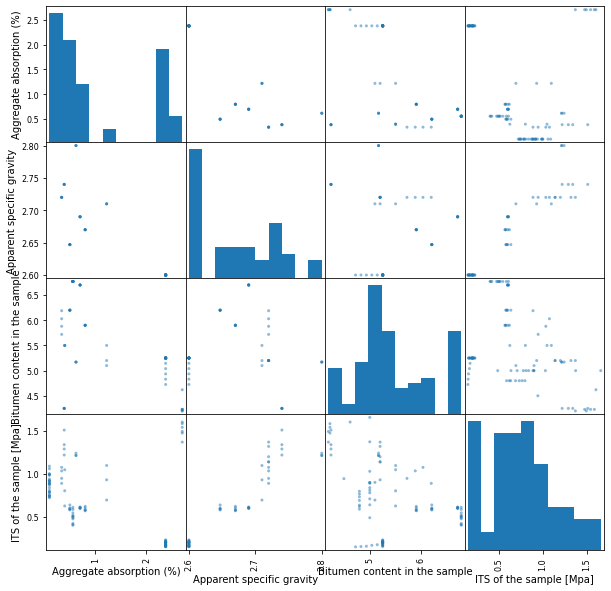

In [10]:
scatter_matrix(dfITS[['Aggregate absorption (%)', 'Apparent specific gravity', 'Bitumen content in the sample', 'ITS of the sample [Mpa]']], figsize=(10, 10))
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap ITS')

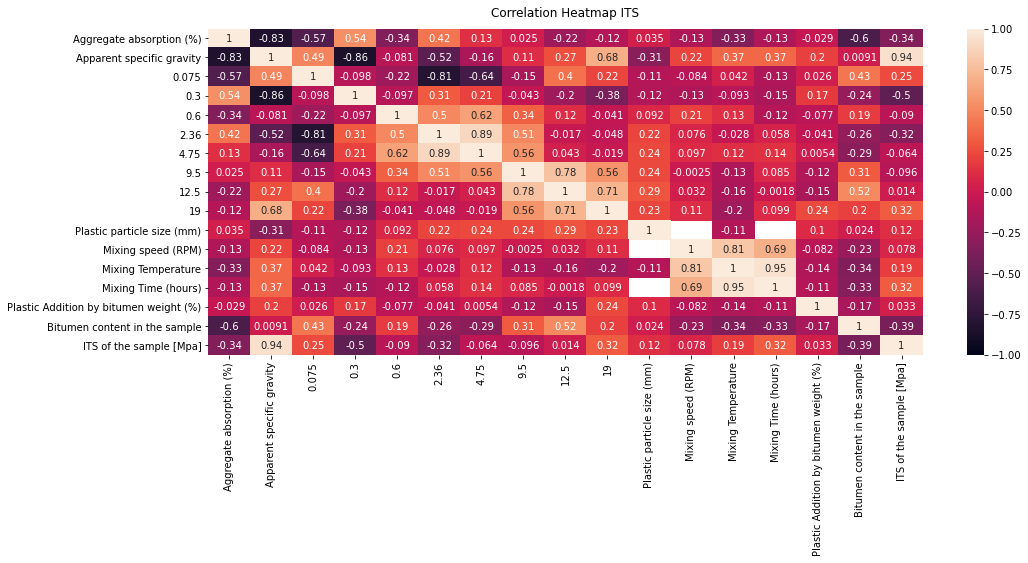

In [11]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfITS.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap ITS', fontdict={'fontsize':12}, pad=12)

The highest positive correlation is with the $\color{red}{\text{Apparent specific gravity}}$ (54% missing values). Negative correlation with $\color{red}{\text{bitumen content}}$ (this is in disagreement with the Asphalt Mixture selection that states a relation between cracking and bitumen content)

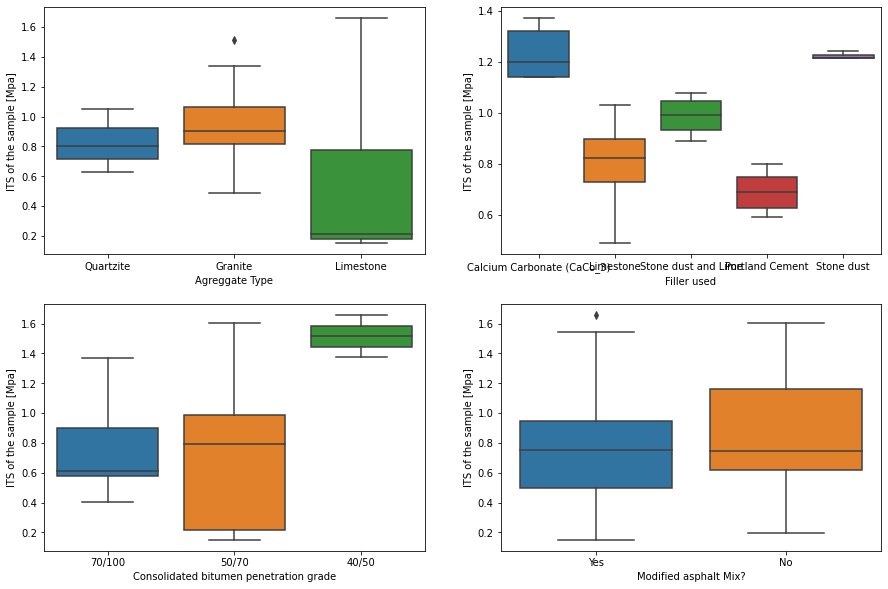

In [12]:
displayBoxPlotGraphs(dataFrame = dfITS, propertyOfInterest = 'ITS of the sample [Mpa]', columnName1 = "Agreggate Type", columnName2 = "Filler used", columnName3 = "Consolidated bitumen penetration grade", columnName4 = "Modified asphalt Mix?")

No difference between modified and unmodified.

###  3.2 Modified mixtures

In [13]:
dfITSModvsUnmod = dfITS [['Modified asphalt Mix?', 'ITS of the sample [Mpa]']]
dfITSModvsUnmod.groupby(['Modified asphalt Mix?'], as_index=False).describe()

ITS of the sample [Mpa]                                                \
                    count      mean       std      min      25%     50%   
0                    16.0  0.880974  0.397912  0.19402  0.62016  0.7429   
1                   105.0  0.737338  0.375573  0.15192  0.50051  0.7500   

                   
     75%      max  
0  1.160  1.60300  
1  0.948  1.65755

In [14]:
dfITSModified = dfITS[dfITS['Modified asphalt Mix?'] == 'Yes']
dfITSModified.iloc[:,2:].describe(include = "all")

Modified asphalt Mix? Agreggate Type  Aggregate absorption (%)  \
count                    105             49                 84.000000   
unique                     1              3                       NaN   
top                      Yes      Limestone                       NaN   
freq                     105             31                       NaN   
mean                     NaN            NaN                  0.975357   
std                      NaN            NaN                  0.958954   
min                      NaN            NaN                  0.100000   
25%                      NaN            NaN                  0.100000   
50%                      NaN            NaN                  0.560000   
75%                      NaN            NaN                  2.375000   
max                      NaN            NaN                  2.700000   

        Apparent specific gravity       0.075         0.3         0.6  \
count                   48.000000  102.000000  102.000000  105.000000   
unique                        NaN         NaN         NaN         NaN   
top                           NaN         NaN         NaN         NaN   
freq                          NaN         NaN         NaN         NaN   
mean                     2.663083    6.089510   14.218627   23.052000   
std                      0.063249    1.641458    2.538724    7.129505   
min                      2.600000    2.990000    5.300000   10.070000   
25%                      2.600000    4.592500   12.432500   18.900000   
50%                      2.658500    5.980000   14.000000   21.250000   
75%                      2.720000    7.000000   16.280000   28.000000   
max                      2.800000    9.700000   23.000000   39.160000   

              2.36        4.75         9.5        12.5          19  \
count   105.000000  105.000000  105.000000  105.000000  105.000000   
unique         NaN         NaN         NaN         NaN         NaN   
top            NaN         NaN         NaN         NaN         NaN   
freq           NaN         NaN         NaN         NaN         NaN   
mean     38.133905   52.150476   73.282857   86.570952   95.039810   
std       9.777670   10.936685    9.894570    8.929621    5.228236   
min      19.770000   23.950000   57.350000   73.040000   89.000000   
25%      33.000000   50.130000   65.000000   79.860000   89.220000   
50%      38.800000   54.770000   70.490000   80.000000   97.230000   
75%      47.000000   54.830000   77.500000   95.090000  100.000000   
max      54.100000   71.080000   96.870000  100.000000  100.000000   

       Filler used Bitumen Type Penetration Grade  \
count           26                            105   
unique           5                              5   
top      Limestone                          60/70   
freq             9                             56   
mean           NaN                            NaN   
std            NaN                            NaN   
min            NaN                            NaN   
25%            NaN                            NaN   
50%            NaN                            NaN   
75%            NaN                            NaN   
max            NaN                            NaN   

       Consolidated bitumen penetration grade New Plastic Type  \
count                                     105              105   
unique                                      3                5   
top                                     50/70               PE   
freq                                       64               40   
mean                                      NaN              NaN   
std                                       NaN              NaN   
min                                       NaN              NaN   
25%                                       NaN              NaN   
50%                                       NaN              NaN   
75%                                       NaN              NaN   
max                                       NaN    

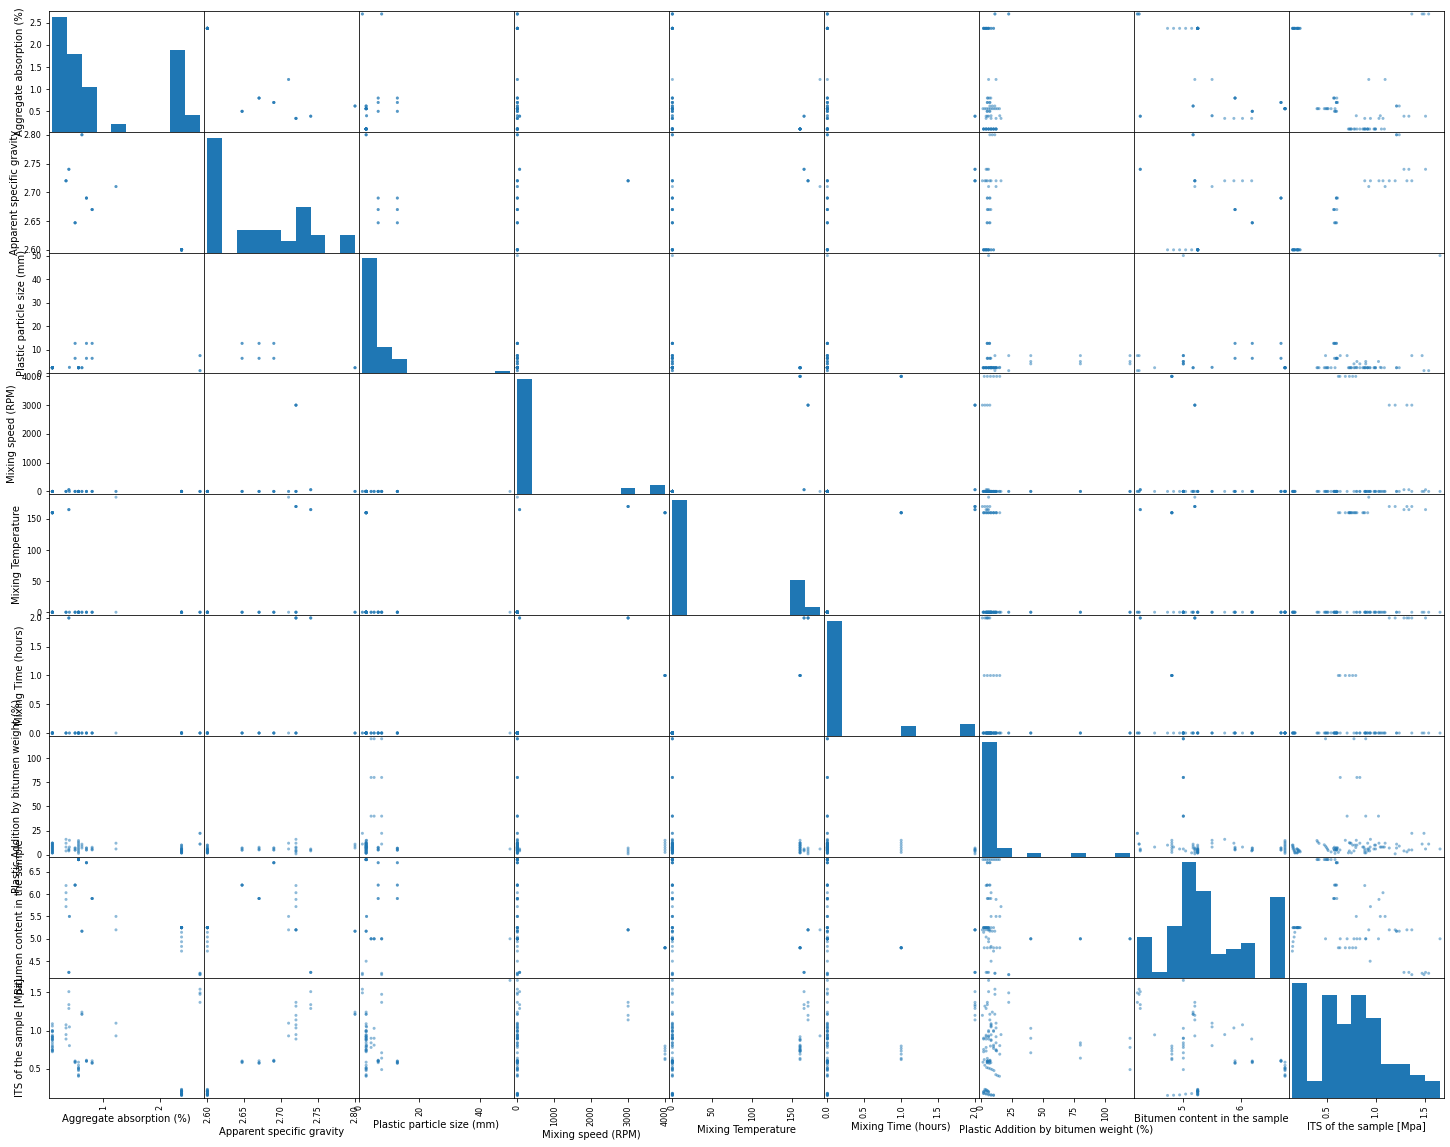

In [15]:
columnsOfInteres = numericColumns[0:2]+numericColumns[10:]+['ITS of the sample [Mpa]']
scatter_matrix(dfITSModified[columnsOfInteres], figsize=(25, 20))
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap ITS')

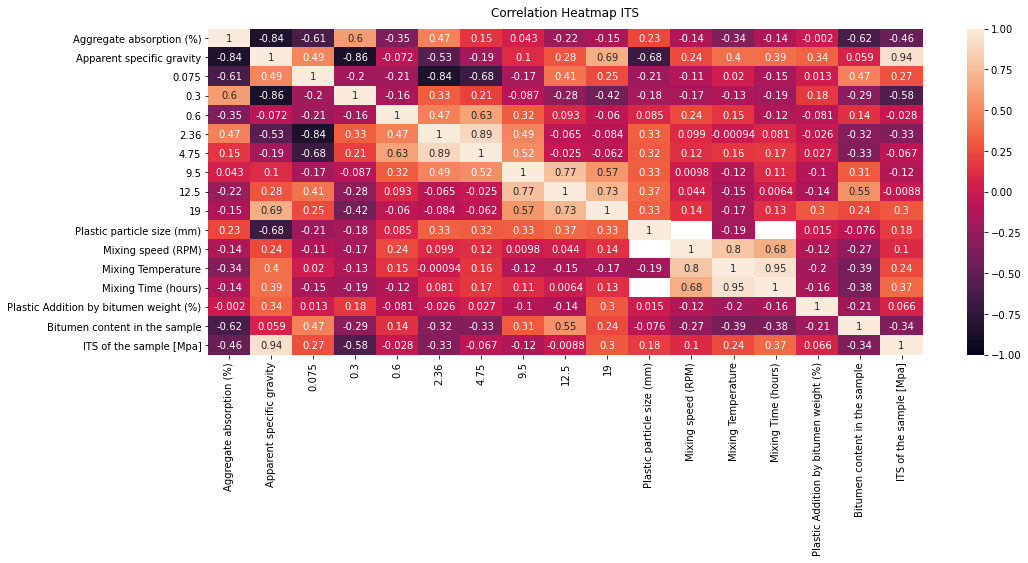

In [16]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfITSModified.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap ITS', fontdict={'fontsize':12}, pad=12)

Some positive correlation in the $\color{red}{\text{mixing parameters}}$ and $\color{red}{\text{gradation}}$. The ITS property does not behave as a normal.

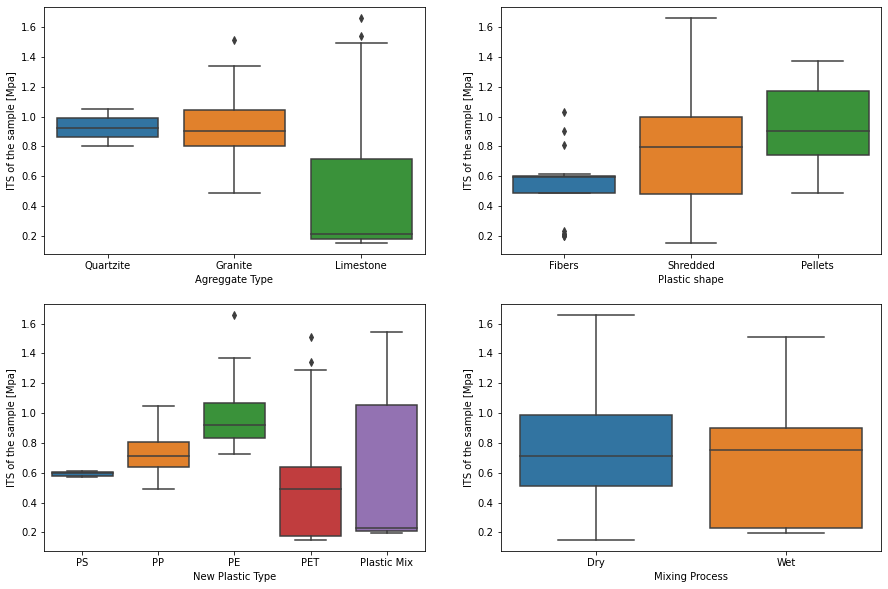

In [17]:
displayBoxPlotGraphs(dataFrame = dfITSModified, propertyOfInterest = "ITS of the sample [Mpa]", columnName1 = "Agreggate Type", columnName2 = "Plastic shape", columnName3 = "New Plastic Type", columnName4 = "Mixing Process")

Possible correlation with $\color{red}{\text{plastic shape}}$, but we need to be aware of the sample size. The dry and wet mixing are very similar.
###  3.3 Wet vs. Dry Mixing

In [18]:
dfITSWetvsDry = dfITSModified [['Mixing Process', 'ITS of the sample [Mpa]']]
dfITSWetvsDry.groupby(['Mixing Process'], as_index=False).describe()

ITS of the sample [Mpa]                                                  \
                    count      mean       std      min       25%      50%   
0                    69.0  0.743882  0.370496  0.15192  0.509520  0.71000   
1                    36.0  0.724796  0.390126  0.19723  0.230548  0.75185   

                    
      75%      max  
0  0.9900  1.65755  
1  0.8975  1.51000

C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


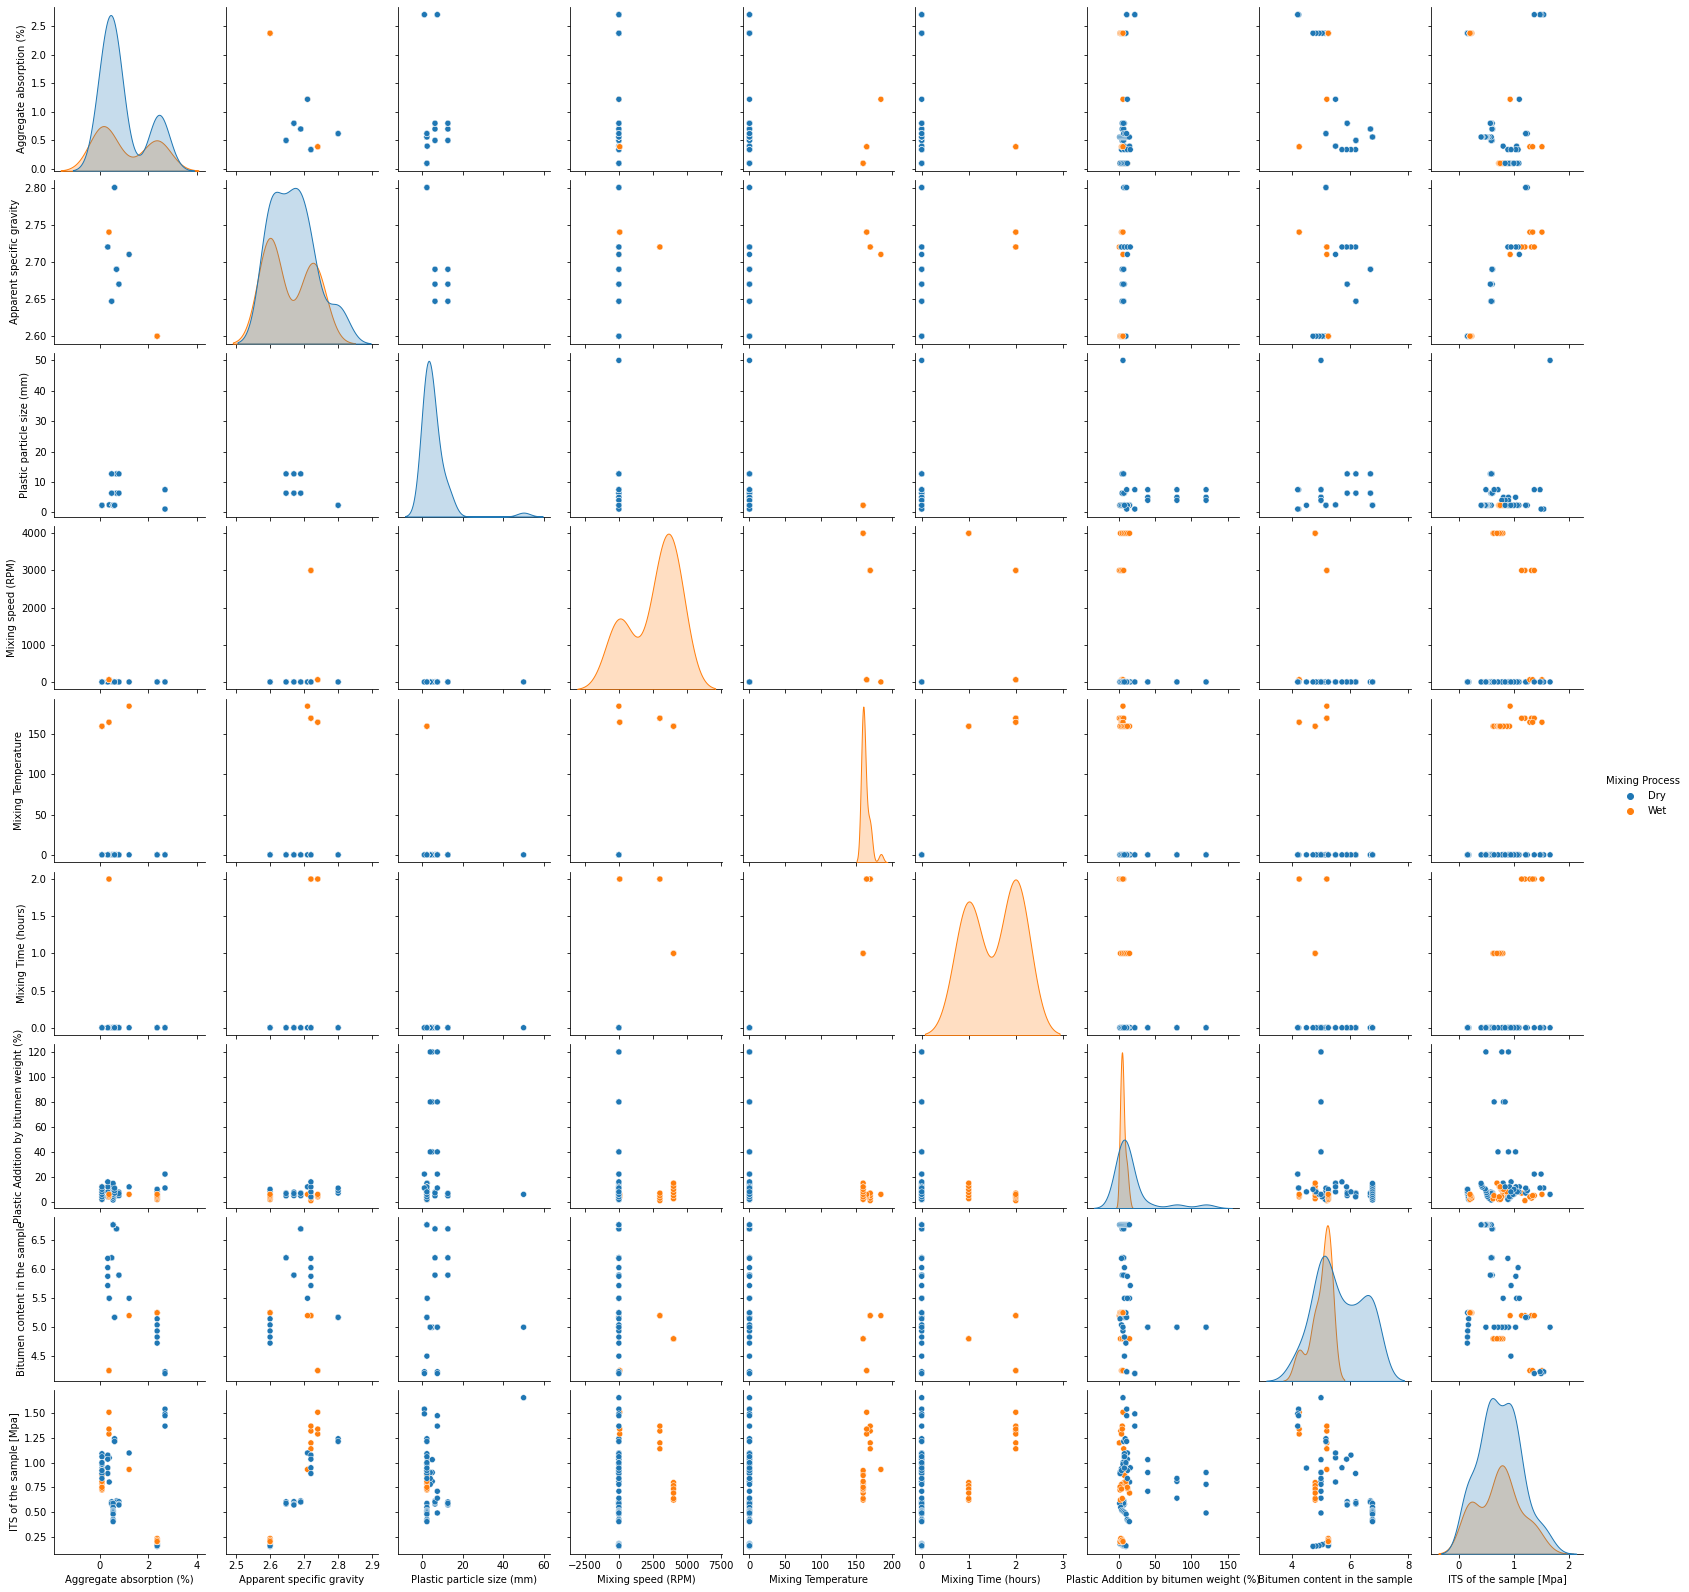

In [19]:
sns.pairplot(dfITSModified[columnsOfInteres+['Mixing Process']], hue="Mixing Process", height=2.5)

##  **Indirect Tensile Strength summary:**

 *  8 outliers were eliminated from the original sample.
 *  Total number of observation: 121 -> $\mu$ = 0.75, $\sigma$ = 0.38.
 *  Major concern with $\color{red}{\text{bitumen quantity}}$ as there are 25 missing values.
 *  $\color{red}{\text{Agregate absorption}}$ has a high number of missing values; 54% of the data points. Nevertheless, it is still an important value according to the Pearson correlation value (r = 0.94)
 *  Negative correlation with $\color{red}{\text{Bitumen quantity}}$.
 *  Not much difference between the modified and unmodified mixtures -> $\mu_{modified}$ = 0.73,  $\mu_{unmodified}$ = 0.88. The observations in unmodified are low (16 obs.), so it is not a conclusive statement.
 *  Modified mixtures present positive correlation with $\color{red}{\text{gradation}}$, $\color{red}{\text{plastic size}}$ (r = 0.12)and  mixing properties; $\color{red}{\text{temperature}}$ (r = 0.19), $\color{red}{\text{mixing time}}$ (r = 0.32).
 *  ITS is not normally distributed.
 *  Not significan difference between dry and wet. Dry has 69 observations ($\mu_{dry}$ = 0.74, $\sigma_{dry}$ = 0.37) while wet has 43 observations ($\mu_{wet}$ = 0.72, $\sigma_{wet}$ = 0.39)

## 4. Data Pre-processing

In [27]:
dfITS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121 entries, 1 to 129
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Article ID                              121 non-null    object 
 1   Global ID                               121 non-null    object 
 2   Modified asphalt Mix?                   121 non-null    object 
 3   Agreggate Type                          57 non-null     object 
 4   Aggregate absorption (%)                95 non-null     float64
 5   Apparent specific gravity               55 non-null     float64
 6   0.075                                   117 non-null    float64
 7   0.3                                     117 non-null    float64
 8   0.6                                     121 non-null    float64
 9   2.36                                    121 non-null    float64
 10  4.75                                    121 non-null    float6

###  Pre-processing:
1.  Eliminate the columns $\color{red}{\text{Article ID}}$, $\color{red}{\text{Global ID}}$, $\color{red}{\text{Aggregate type}}$, $\color{red}{\text{Apparent specific gravity}}$, $\color{red}{\text{filler used}}$, $\color{red}{\text{Bitumen type penetration grade}}$, $\color{red}{\text{plastic size}}$, $\color{red}{\text{Property}}$ and $\color{red}{\text{Units}}$.
2.  Change the N/a to zero. This is for the unmodified mixtures.
4.  Change categorical columns to numeric - $\color{red}{\text{Modified asphalt Mix?}}$, $\color{red}{\text{Consolidated bitumen penetration grade}}$, $\color{red}{\text{New Plastic Type}}$, $\color{red}{\text{Plastic pretreatment}}$, $\color{red}{\text{Plastic shape}}$, $\color{red}{\text{Mixing Process}}$, $\color{red}{\text{Plastic melted previous to addition?}}$, $\color{red}{\text{Replacements}}$.
5.  Imputer to $\color{red}{\text{Aggregate absorption}}$, $\color{red}{\text{gradations}}$, $\color{red}{\text{plastic size(mm)}}$, $\color{red}{\text{mixing parameters}}$ and $\color{red}{\text{Bitumen content in the sample}}$.

In [28]:
#Categorical Variables
dfITSCleaned = dfITS.drop(['Article ID', 
                        'Global ID',
                        'Modified asphalt Mix?',
                        'Agreggate Type', 
                        'Apparent specific gravity', 
                        'Filler used', 
                        'Bitumen Type Penetration Grade',
                        'Plastic Size', 
                        'Property', 
                        'Units'], axis = 1)
dfITSCleaned = dfITSCleaned.replace('N/a', 0)
dfITSCleaned = pd.get_dummies(dfITSCleaned, columns=['New Plastic Type'], drop_first = False)
dfITSCleaned = pd.get_dummies(dfITSCleaned, drop_first=True)
dfITSCleaned = dfITSCleaned.drop(['New Plastic Type_0'], axis = 1)
dfITSCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121 entries, 1 to 129
Data columns (total 32 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Aggregate absorption (%)                       95 non-null     float64
 1   0.075                                          117 non-null    float64
 2   0.3                                            117 non-null    float64
 3   0.6                                            121 non-null    float64
 4   2.36                                           121 non-null    float64
 5   4.75                                           121 non-null    float64
 6   9.5                                            121 non-null    float64
 7   12.5                                           121 non-null    float64
 8   19                                             121 non-null    float64
 9   Plastic particle size (mm)                     82 non-

In [29]:
#IMPUTATION OF MISSING VALUES
imputer = IterativeImputer (estimator = ExtraTreesRegressor(n_estimators=10, random_state=0), max_iter=100)
n = imputer.fit_transform(dfITSCleaned)
dfITSCleanedImputed = pd.DataFrame(n, columns = list(dfITSCleaned.columns))
dfITSCleanedImputed.info()
print ('There is '+str(sum(n < 0 for n in dfITSCleanedImputed.values.flatten()))+' negative values in the new Dataframe')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 32 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Aggregate absorption (%)                       121 non-null    float64
 1   0.075                                          121 non-null    float64
 2   0.3                                            121 non-null    float64
 3   0.6                                            121 non-null    float64
 4   2.36                                           121 non-null    float64
 5   4.75                                           121 non-null    float64
 6   9.5                                            121 non-null    float64
 7   12.5                                           121 non-null    float64
 8   19                                             121 non-null    float64
 9   Plastic particle size (mm)                     121 non

In [30]:
dfITSCleanedImputed['New Plastic Type_PE'] = dfITSCleanedImputed['New Plastic Type_PE'] * dfITSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfITSCleanedImputed['New Plastic Type_PET'] = dfITSCleanedImputed['New Plastic Type_PET'] * dfITSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfITSCleanedImputed['New Plastic Type_PP'] = dfITSCleanedImputed['New Plastic Type_PP'] * dfITSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfITSCleanedImputed['New Plastic Type_PS'] = dfITSCleanedImputed['New Plastic Type_PS'] * dfITSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfITSCleanedImputed['New Plastic Type_Plastic Mix'] = dfITSCleanedImputed['New Plastic Type_Plastic Mix'] * dfITSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfITSCleanedImputed = dfITSCleanedImputed.drop(['Plastic Addition by bitumen weight (%)'], axis = 1)

In [31]:
scaler = MinMaxScaler()
dfITSCleanedImputedScaled = pd.DataFrame(scaler.fit_transform(dfITSCleanedImputed), columns = list(dfITSCleanedImputed.columns))
dfITSCleanedImputedScaled.to_clipboard()

## 5. Model Training

In [32]:
X = dfITSCleanedImputedScaled.loc[:, dfITSCleanedImputedScaled.columns != 'ITS of the sample [Mpa]']
y = dfITSCleanedImputedScaled.loc[:,'ITS of the sample [Mpa]']
cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 123)

### 5.1 Model Evaluation
#### Linear Model

In [30]:
param_grid = {'fit_intercept': [True, False],
            'positive': [True, False]}
grid = GridSearchCV(LinearRegression(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

Best Parameters: {'fit_intercept': True, 'positive': False}
Best MSE:0.025313478100437714


#### Lasso Linear Model

In [31]:
param_grid = {'alpha': [0.001,1,2, 10, 15, 30, 50, 100],
            'fit_intercept':[True, False],
            'positive': [True, False]}
grid = GridSearchCV(Lasso(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025822911100033208, tolerance: 0.0022806130786960574
  model = cd_fast.enet_coordinate_descent(
C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006318402906911991, tolerance: 0.001977360604633948
  model = cd_fast.enet_coordinate_descent(
C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00907416842386688, tolerance: 0.0021281817513844276
  model = cd_fast.enet_coordinate_descent(
C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages

#### Ridge Linear Regression Model

In [32]:
param_grid = {'alpha': [0,5,15,100],
'fit_intercept': [True, False],
'solver': [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
grid = GridSearchCV(Ridge(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit = 'neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.14817e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.9958e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.00466e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.14959e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditi

#### Linear elastic Net

In [33]:
param_grid = {'alpha': [0.01,1,2,3,4],
'fit_intercept': [True, False]}
grid = GridSearchCV(ElasticNet(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit = 'neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

Best Parameters: {'alpha': 0.01, 'fit_intercept': True}
Best MSE:0.021263072312453894


#### Polynomial model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Ridge(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
'ridge__alpha':[10, 20,30,50],
'ridge__fit_intercept': [True, False],
'ridge__solver': [ 'lsqr', 'cholesky', 'sparse_cg', 'svd', 'sag']}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

#### Lasso polynomial model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Lasso(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3,4],
            'lasso__alpha': [1, 10, 15, 30, 50, 100],
            'lasso__fit_intercept':[True, False],
            'lasso__positive': [True, False],
            'lasso__max_iter': [3000]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

#### Ridge Polynomial Model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Ridge(**kwargs))

param_grid = {'polynomialfeatures__degree': [3,4],
'ridge__alpha':[10, 20,30,50],
'ridge__fit_intercept': [True, False],
'ridge__solver': [ 'lsqr', 'cholesky', 'sparse_cg', 'svd', 'sag']}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error'')
grid.fit(X, y)
printBestModel(grid)

#### Support Vector Regression

In [34]:
param_grid = {
    'kernel':['linear','rbf', 'sigmoid','poly'],
    'degree':[2,3],
    'C':[0.01,1,5,10],
    'epsilon':[0.1,0.5, 1, 1.5]
}
grid = GridSearchCV(SVR(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

Best Parameters: {'C': 5, 'degree': 2, 'epsilon': 0.1, 'kernel': 'poly'}
Best MSE:0.012059560299491885


#### Decision tree regresor

In [35]:
param_grid = {
    'max_depth':[None,2,3,5,10],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[1,2,5],
    'max_leaf_nodes': [None, 5,10]
}
grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

Best Parameters: {'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best MSE:0.006989740866792266


#### Random Forest

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = RandomizedSearchCV(RandomForestRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error', n_iter=100)
grid.fit(X, y)
printBestModel(grid)

#### Extra tree regressor

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = RandomizedSearchCV(ExtraTreesRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error', n_iter=100)
grid.fit(X, y)
printBestModel(grid)

#### XG Boost Regressor

In [14]:
XGBoostModel = XGBRegressor()
scores = cross_val_score(XGBoostModel, X, y , scoring = 'neg_mean_squared_error', cv = cv)
scores = np.absolute(scores)
print (scores.mean())

0.006216639288683427


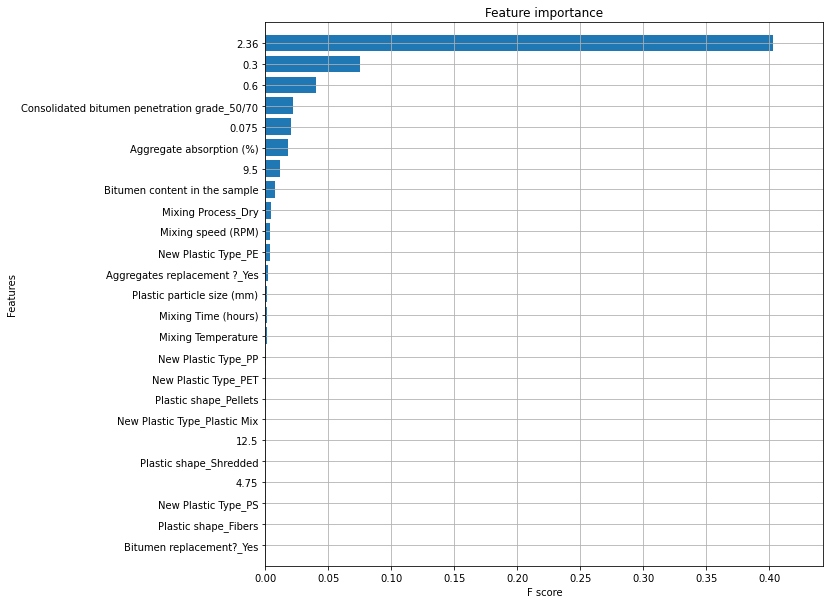

In [15]:
#Graph employed for selecting important features during tunning
XGBoostModel.fit(X,y)
ax = plot_importance(XGBoostModel, height=0.8, importance_type='gain', show_values=False)
fig = ax.figure
fig.set_size_inches(10,10)

## 6. Best Model Tunning

In [16]:
X.columns = X.columns.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
cv = RepeatedKFold(n_splits = 5, n_repeats = 15, random_state = 123)

### 6.1. Feature selection

In [17]:
features_MSE = {}
def addMSE (columns, string):
    cv_results = cross_validate(XGBRegressor(random_state = 123), X_train[columns], y_train, cv = cv, scoring = ['neg_mean_squared_error'])
    MSE = np.average(-cv_results['test_neg_mean_squared_error'])
    features_MSE[string] = MSE

In [18]:
X_train.columns

Index(['Aggregate absorption (%)', '0.075', '0.3', '0.6', '2.36', '4.75',
       '9.5', '12.5', '19', 'Plastic particle size (mm)', 'Mixing speed (RPM)',
       'Mixing Temperature', 'Mixing Time (hours)',
       'Bitumen content in the sample', 'New Plastic Type_PE',
       'New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
       'New Plastic Type_Plastic Mix',
       'Consolidated bitumen penetration grade_50/70',
       'Consolidated bitumen penetration grade_70/100',
       'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
       'Plastic shape_Fibers', 'Plastic shape_Pellets',
       'Plastic shape_Shredded', 'Mixing Process_Dry', 'Mixing Process_Wet',
       'Aggregates replacement ?_Yes', 'Bitumen replacement?_Yes'],
      dtype='object')

In [19]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19'], 
'Gradation')

In [20]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
    'Aggregate absorption (%)'], 
    'Gradation \n Agg. absorption')

In [21]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
    'Aggregate absorption (%)',
    'Mixing Temperature'], 
    'Gradation \n Agg. absorption \n Mixing temp.')

In [22]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
    'Aggregate absorption (%)',
    'Mixing Temperature',
    'Bitumen content in the sample'], 
    'Gradation \n Agg. absorption \n Mixing temp. \n Bitumen content')

In [23]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
    'Aggregate absorption (%)',
    'Mixing Temperature',
    'Bitumen content in the sample',
    'New Plastic Type_PE','New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
    'New Plastic Type_Plastic Mix'], 
    'Gradation \n Agg. absorption \n Mixing temp. \n Bitumen content \n Plastic type')

In [24]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
    'Aggregate absorption (%)',
    'Mixing Temperature',
    'Bitumen content in the sample',
    'New Plastic Type_PE','New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
    'New Plastic Type_Plastic Mix',
    'Plastic particle size (mm)',
    'Consolidated bitumen penetration grade_50/70',
    'Consolidated bitumen penetration grade_70/100'], 
    'Gradation \n Agg. absorption \n Mixing temp. \n Bitumen content \n Plastic type \n Plastic size \n Bitumen type')

In [25]:
addMSE(['Aggregate absorption (%)', '0.075', '0.3', '0.6', '2.36', '4.75',
       '9.5', '12.5', '19', 'Plastic particle size (mm)', 'Mixing speed (RPM)',
       'Mixing Temperature', 'Mixing Time (hours)',
       'Bitumen content in the sample', 'New Plastic Type_PE',
       'New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
       'New Plastic Type_Plastic Mix',
       'Consolidated bitumen penetration grade_50/70',
       'Consolidated bitumen penetration grade_70/100',
       'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
       'Plastic shape_Fibers', 'Plastic shape_Pellets',
       'Plastic shape_Shredded', 'Mixing Process_Dry', 'Mixing Process_Wet',
       'Aggregates replacement ?_Yes', 'Bitumen replacement?_Yes'], 
    'Gradation \n Agg. absorption \n Mixing temp. \n Bitumen content \n Plastic type \n Plastic size \n Bitumen type \n Rest of features')

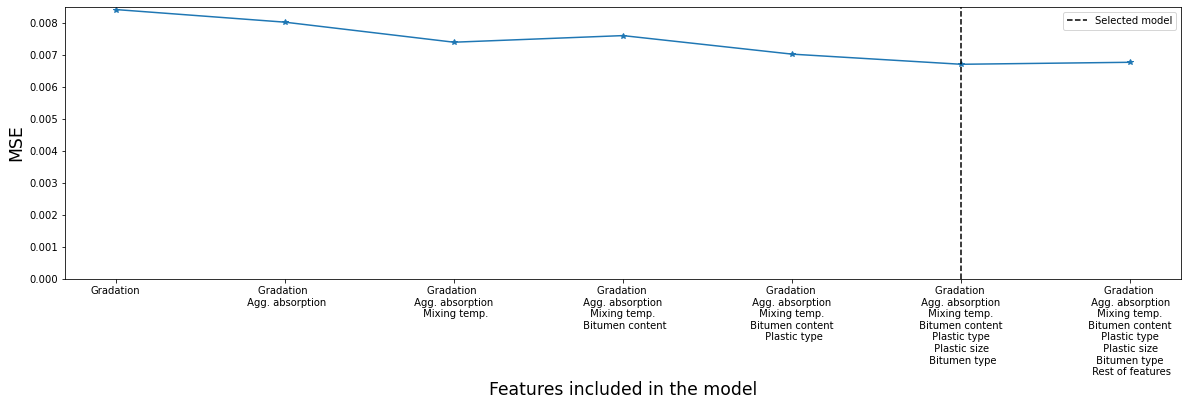

In [26]:
 plt.rcParams["figure.figsize"] = (20,5)
 plt.plot(features_MSE.keys(), features_MSE.values(), marker = '*') 
 plt.ylim(ymin = 0)
 plt.axvline(x='Gradation \n Agg. absorption \n Mixing temp. \n Bitumen content \n Plastic type \n Plastic size \n Bitumen type', ymin=0, ymax=1, color = 'k', ls = '--' , label='Selected model')
 plt.ylabel('MSE', fontsize = 'xx-large')
 plt.xlabel('Features included in the model', fontsize = 'xx-large')
 plt.legend()
 plt.show()

The features most approppiate for the model are aggregates gradation, bitumen content, plastic type, plastic addition.
### 6.2 Model Tunning

In [27]:
def tuning_evaluation (parameters, X, y):
    param_grid = parameters
    grid = GridSearchCV(XGBRegressor(random_state = 1), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
    grid.fit(X, y)
    test_MSE = -grid.cv_results_['mean_test_neg_mean_squared_error'][grid.best_index_]
    test_r2 = grid.cv_results_['mean_test_r2'][grid.best_index_]
    best_param = grid.best_params_
    print ('r2 test: ' + str(test_r2))
    print ('MSE test: ' + str(test_MSE))
    print ('Best Parameters ' + str(best_param))

In [17]:
X_train = X_train[['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
    'Aggregate absorption (%)',
    'Mixing Temperature',
    'Bitumen content in the sample',
    'New Plastic Type_PE','New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
    'New Plastic Type_Plastic Mix',
    'Plastic particle size (mm)',
    'Consolidated bitumen penetration grade_50/70',
    'Consolidated bitumen penetration grade_70/100']]
X_test = X_test[['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
    'Aggregate absorption (%)',
    'Mixing Temperature',
    'Bitumen content in the sample',
    'New Plastic Type_PE','New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
    'New Plastic Type_Plastic Mix',
    'Plastic particle size (mm)',
    'Consolidated bitumen penetration grade_50/70',
    'Consolidated bitumen penetration grade_70/100']]

In [54]:
param_grid = {
        'eta':[0.1, 0.2, 0.3, 0.4, 0.5]
    }
tuning_evaluation (param_grid, X_train, y_train)

r2 test: 0.8900845777136512
MSE test: 0.006599122109504968
Best Parameters {'eta': 0.4}


In [55]:
param_grid = {
        'eta':[0.4],
        'max_depth':np.arange(3,11,1)
    }
tuning_evaluation (param_grid, X_train, y_train)

r2 test: 0.8923189784355098
MSE test: 0.006176372041233054
Best Parameters {'eta': 0.4, 'max_depth': 4}


In [56]:
param_grid = {
        'eta':[0.4],
        'max_depth':[4],
        'min_child_weight':np.arange(1,11,1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

r2 test: 0.8923189784355098
MSE test: 0.006176372041233054
Best Parameters {'eta': 0.4, 'max_depth': 4, 'min_child_weight': 1}


In [57]:
param_grid = {
        'eta':[0.4],
        'max_depth':[4],
        'min_child_weight':[1],
        'max_delta_step': np.arange(0,11,1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

r2 test: 0.8923189784355098
MSE test: 0.006176372041233054
Best Parameters {'eta': 0.4, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1}


In [58]:
param_grid = {
        'eta':[0.4],
        'max_depth':[4],
        'min_child_weight':[1],
        'max_delta_step': [0],
        'gamma' : [0, 0.001, 0.01, 0.1, 1, 10]
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

r2 test: 0.8923189784355098
MSE test: 0.006176372041233054
Best Parameters {'eta': 0.4, 'gamma': 0, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1}


In [68]:
param_grid = {
        'eta':[0.4],
        'max_depth':[4],
        'min_child_weight':[1],
        'max_delta_step': [0],
        'gamma' : [0],
        'lambda' : np.arange(1,10,1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

r2 test: 0.9020387210772702
MSE test: 0.005831309748849555
Best Parameters {'eta': 0.4, 'gamma': 0, 'lambda': 3, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1}


In [21]:
param_grid = {
        'eta':[0.4],
        'max_depth':[4],
        'min_child_weight':[1],
        'max_delta_step': [0],
        'gamma' : [0],
        'lambda' : [3],
        'alpha' : np.arange(0,11,1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

NameError: name 'tuning_evaluation' is not defined

### 6.3 Final model evaluation on test set

In [18]:
XGModel = XGBRegressor(random_state=123)
XGModel.fit(X_train, y_train)
predictions_test = XGModel.predict(X_test)
r2_test = r2_score(y_test, predictions_test)
mse_test = mean_squared_error(y_test, predictions_test)
print('The test r2 is: ' + str(r2_test))
print('The test MSE is: ' + str(mse_test))
predictions_train = XGModel.predict(X_train)
r2_train = r2_score(y_train, predictions_train)
mse_train = mean_squared_error(y_train, predictions_train)
print('The train r2 is: ' + str(r2_train))
print('The train MSE is: ' + str(mse_train))

The test r2 is: 0.9442421973124584
The test MSE is: 0.0024044846975676075
The train r2 is: 0.9996353074709542
The train MSE is: 2.4753287362635774e-05


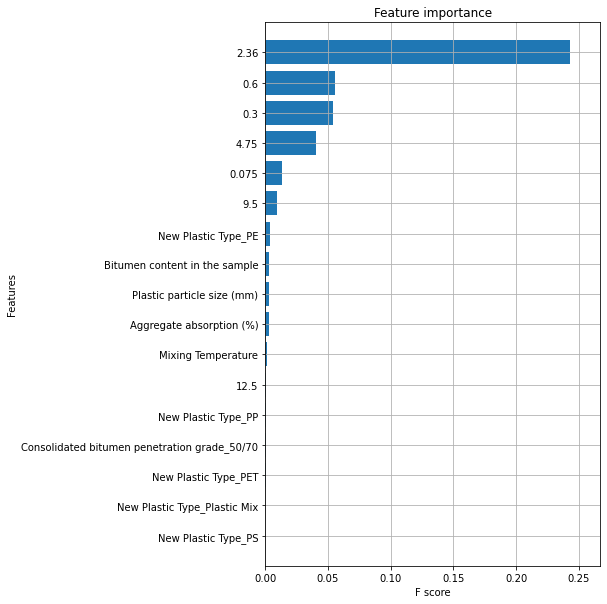

In [19]:
ax = xgb.plot_importance(XGModel, height=0.8, importance_type = 'gain', show_values = False)
fig = ax.figure
fig.set_size_inches(6,10)

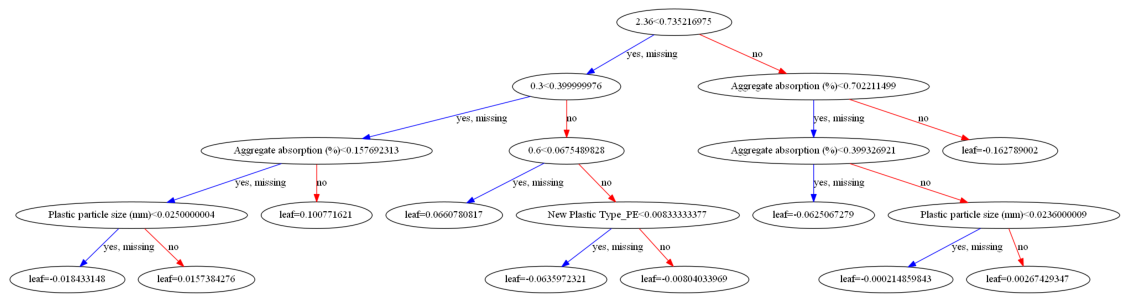

In [72]:
ax = xgb.plot_tree(XGModel)
fig = ax.figure
fig.set_size_inches(20,20)